In [105]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import requests
from scipy.integrate import odeint

In [106]:
# Fetches the data from the COVID19India website
class DataFetcher:
    def __init__(self, url="https://api.covid19india.org/data.json"):
        self.url = url
        self.json_data = None
        self.cases_time_series = None
        
    def fetch(self):
        r = requests.get(url=self.url)
        self.json_data = r.json()
        
        # Get the fields
        fields = list(self.json_data['cases_time_series'][0].keys())
        self.cases_time_series = {}
        
        for field in fields:
            if field == 'date':
                self.cases_time_series[field] = [x[field] for x in self.json_data['cases_time_series']]
            else:
                self.cases_time_series[field] = np.array([float(x[field]) for x in self.json_data['cases_time_series']])

<h2>A time dependent SIR model</h2>

$$  \frac{dS}{dt} = -\frac{\beta IS}{N} \tag1 $$
$$    \frac{dI}{dt} = \frac{\beta IS}{N} - \gamma I \tag2 $$
$$    \frac{dR}{dt} = \gamma I \tag3 $$


In [133]:
fetcher = DataFetcher()
fetcher.fetch()

In [167]:
# Return a solved differential equation
def sir_model(xdata, beta, gamma):
    def f(vals, t, beta, gamma):
        S, I, R = vals
        S_dot = -beta * I * S
        I_dot = beta * I* S - gamma * I
        R_dot = gamma * I
        return [S_dot, I_dot, R_dot]
    
    results = odeint(f, [1.0, 8.334e-10, 0], xdata, args=(beta,gamma))
    return results[:, 1]

In [190]:
start_day = 35
end_day = 61
xdata = np.array(range(end_day - start_day))
ydata = np.ones((end_day - start_day, 3))
pop = 1.2e9
ydata[:, 2] = (fetcher.cases_time_series['totaldeceased'][start_day:end_day] + fetcher.cases_time_series['totalrecovered'][start_day:end_day]) / pop
ydata[:, 1] = (fetcher.cases_time_series['totalconfirmed'][start_day:end_day] / pop) - ydata[:, 2]
ydata[:, 0] -= (ydata[:, 1]  + ydata[:, 2])

In [205]:
results = curve_fit(sir_model, xdata, ydata[:, 1], p0=(1e-7, 0.01))
length = len(fetcher.cases_time_series['totalconfirmed'])
preds = sir_model(range(length), results[0][0], results[0][1])

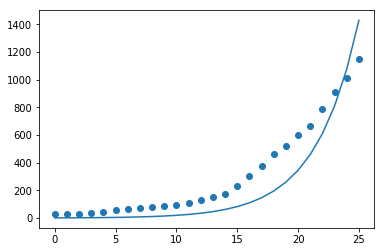

In [203]:
plt.scatter(range(, fetcher.cases_time_series['totalconfirmed'], label="Actual values")
plt.plot(xdata, preds * pop, label="Predictions")
plt.show()